# SVD para recomendar programas

In [1]:
import pandas as pd
import numpy as np
import random
import sys

df = pd.read_csv('data/user_program_count.csv', header=0)
df.columns = ['user_id', 'program_id', 'download_count', 'download_updated']

print(df.head())
print('\nMemory taken by the dataframe: ' + str(sys.getsizeof(df)//(2**20)) + 'MB')

   user_id  program_id  download_count     download_updated
0       43          96              27  2016-04-11 00:15:03
1       43         100              16                  NaN
2       43         112              24                  NaN
3       43         164               5                  NaN
4       43         213              24  2017-02-27 00:28:18

Memory taken by the dataframe: 2414MB


In [2]:
df["user_id"] = df["user_id"].astype(str)
df["program_id"] = df["program_id"].astype(str)
df['download_count'] = df['download_count'].astype(int)
df['download_updated'] = pd.to_datetime(df['download_updated'], errors = 'coerce')
users = df['user_id'].unique()
programs = df['program_id'].unique()

print('Número de entradas de las base de datos: ' + str(len(df)))
print('Número de programas en total: '+ str(len(programs)))
print('Número de usuarios: ' + str(len(users)))

print('\nMemory taken by the dataframe: ' + str(sys.getsizeof(df)//(2**20)) + 'MB')

Número de entradas de las base de datos: 25353339
Número de programas en total: 179587
Número de usuarios: 3345446

Memory taken by the dataframe: 3330MB


Hay muchos programas, vamos a intentar limpiar un poco eliminando programas viejos o aquellos que o los escuchan casi personas.

In [3]:
count_prog = df.groupby('program_id')['user_id'].nunique()

In [4]:
sum(count_prog.isin([1,2]))

80680

In [5]:
count_prog.describe()

count    179587.000000
mean        141.175803
std        2448.833892
min           1.000000
25%           1.000000
50%           3.000000
75%          14.000000
max      356581.000000
Name: user_id, dtype: float64

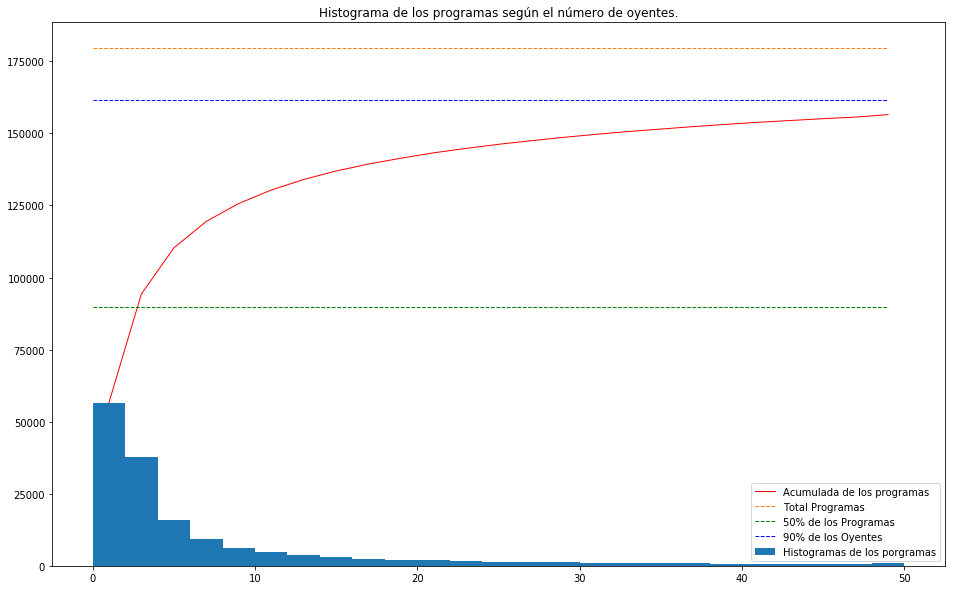

In [6]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

X = count_prog.tolist()

plt.figure(figsize=(16,10))
plt.title('Histograma de los programas según el número de oyentes.')
max_size = 25
n, bins, patches = plt.hist(X, bins=max_size, range=(0,2*max_size), cumulative=0, normed=0)
plt.plot(bins[1:]-1, np.cumsum(n),'-r',linewidth = 1)
plt.plot([len(count_prog) for i in range(2*max_size)], '--', linewidth = 1)
plt.plot([0.5*len(count_prog) for i in range(2*max_size)], '--g', linewidth = 1)
plt.plot([0.90*len(count_prog) for i in range(2*max_size)], '--b', linewidth = 1)
plt.legend([ 'Acumulada de los programas', 'Total Programas', '50% de los Programas', '90% de los Oyentes','Histogramas de los porgramas'])

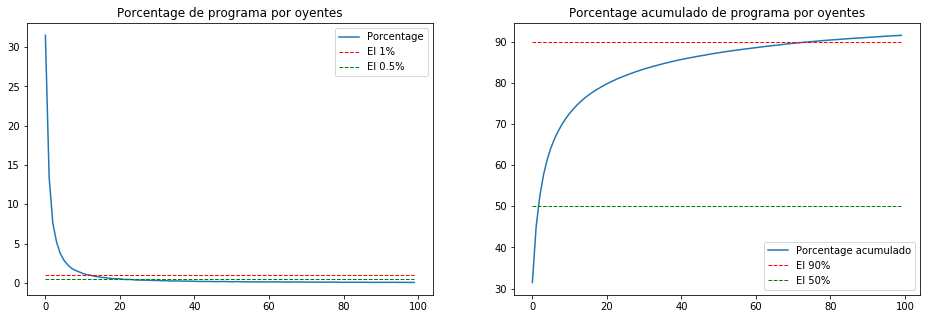

In [7]:
percentage=[]
for i in range(1,101): #len(count_prog)+1):
    p = sum(count_prog==i)/len(count_prog)*100
    percentage.append(p)
acumulada = np.cumsum(percentage)
np.append(acumulada,1)


plt.close()
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.title('Porcentage de programa por oyentes')
plt.plot(percentage)
plt.plot([1 for i in range(len(percentage))], '--r', linewidth=1)
plt.plot([0.5 for i in range(len(percentage))], '--g', linewidth=1)
plt.legend(['Porcentage', 'El 1%', 'El 0.5%'])
plt.subplot(1,2,2)
plt.title('Porcentage acumulado de programa por oyentes')
plt.plot(acumulada)
plt.plot([90 for i in range(len(acumulada))], '--r', linewidth = 1)
plt.plot([50 for i in range(len(acumulada))], '--g', linewidth = 1)
plt.legend(['Porcentage acumulado', 'El 90%', 'El 50%'])

Veamos la distribucion de las fechas para ver si también hay algún patrón que se pueda eliminar, como programas que no se oyen desde hace meses.

In [5]:
from datetime import datetime
print('Numero de programas que no son escuchados por nadie desde el 2015: '+ str(len(programs)-len(df[df['download_updated']>datetime(2015,1,1,0,0,0)].program_id.unique())))

Numero de programas que no son escuchados por nadie desde el 2015: 9759


Casi 10000 programas que no se escuchan desde 2015, como estos es posible que halla muchos.

Todos estos programas dificultan la recomendación de programas, ya que solo representan ruido que nadie escucha, ahora mismo no supone ningun probema pues se usa una muestra aleatoria por lo que problemas que aparecen no tienden a aparecer. De todas formas la forma en la que cogemos los datos no perjudica a los programas que aparecen poco tanto como podría, por lo que quitarlo de antemano no solo ayuda a evitar ruido en los datos, sino que también beneficia al educir las dimensiones de la matriz.

## En la siguiente celda realizamos lo siguiente

* Limpiar por fecha y por número de apariciones, tratando de reducir la dimensión hasta el punto de que no sea necesario un tratamiento tan selectivo de los datos.
* Localizamos los programas sin escuchas desde una fecha dada y los ignoramos.

In [6]:
from datetime import datetime

entradas_origen = len(df)
programas_fecha = df[df['download_updated']>datetime(2015,1,1,0,0,0)].program_id.unique() #programas que se han escuchado una vez desde 2015
df = df[df.program_id.isin(programas_fecha)]
rango_oyentes = range(1,11)
programas_oyentes = df[~df.program_id.isin(count_prog[count_prog.isin(rango_oyentes)].index)].program_id.unique()#programas que solo son escuchados entre 1 y 10 
df = df[df.program_id.isin(programas_oyentes)]
print('Antes teníamos ' + str(len(programs)) + ', ahora tenemos un total de ' + str(len(df.program_id.unique())) + ' programas.')
print('Ésto implica que de una base de datos de ' + str(entradas_origen) + ' de entradas hemos pasado a una con ' + str(len(df)) + ' entradas.')
new_users = df['user_id'].unique()
new_programs = df['program_id'].unique()

Antes teníamos 179587, ahora tenemos un total de 51298 programas.
Ésto implica que de una base de datos de 25353339 de entradas hemos pasado a una con 24953873 entradas.


No parece que halla mucha diferencia en la base de datos, pero la diferencia en el número de programas reduce drásticamente la dimensión de la matriz. Teniendo como consecuencia una matriz más manejable. Veamos de nuevo la distribución por fechas de la base reducida.

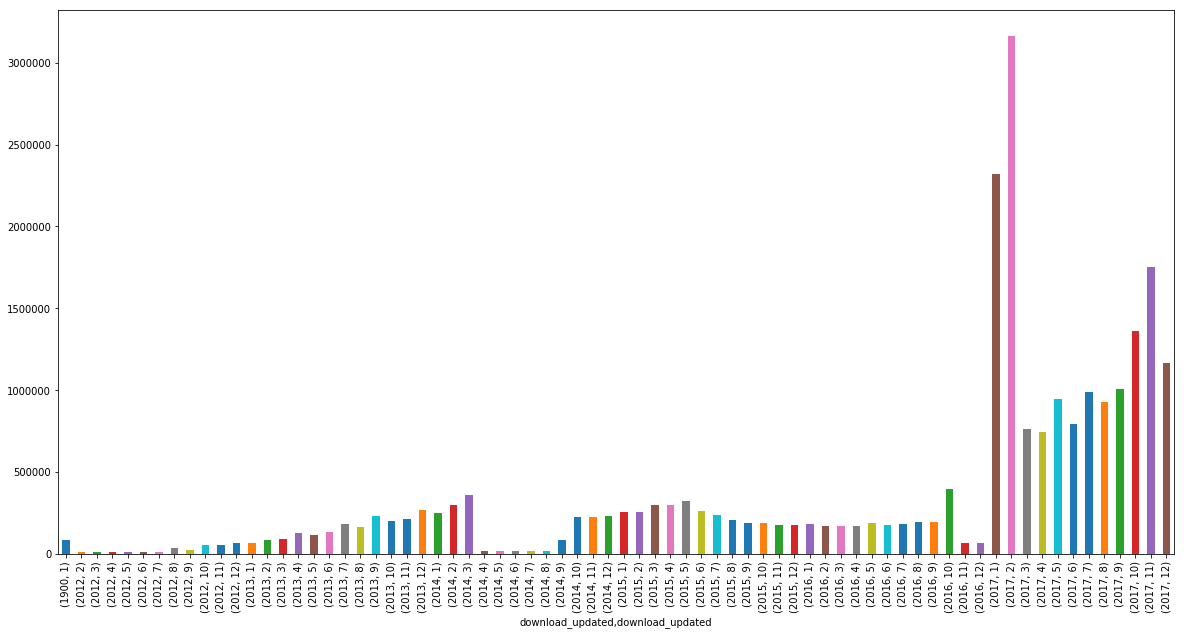

In [10]:
count_by_date = df.fillna(datetime(1900,1,1,0,0,0))
count_by_date = count_by_date.groupby([count_by_date["download_updated"].dt.year, count_by_date["download_updated"].dt.month]).count()
count_by_date['download_updated'].plot(kind="bar", figsize=(20,10))

En la gráfica anterior es posible ver las fechas en las que una persona hizo la descarga de un programa. El hueco ocurrido entre abril de 2041 y sptiembre de 2014 tengo la sospecha de que se trata por un fallo técnico, de todas formas se puede ignorar. Cabe destacar que para poder poner los NaT's en elgráfico de barras se les ha dado un valor auxiliar (1 de enero de 1900, a las 00:00 horas), por ello se puede ver en la gráfica que hay un número de podcasts actualizados en 1900. Viedno esta distribución, se probará como los programas a eliminar todos aquellos usuarios que no han tenido actividad desde antes de 2015.

In [11]:
print('Numero de usuarios inactivos desde el 1 de enero de 2015: '+ str(len(new_users)-len(df[df['download_updated']>datetime(2015,1,1,0,0,0)].user_id.unique())))

Numero de usuarios inactivos desde el 1 de enero de 2015: 588370


Casi medio millón de usuarios no han escuchado nada desde entonces, eliminar estos usuarios podría beneficiar en cuanto a que podemos quitar datos desfasados y usuarios cuya información no es actual y solo produce ruido en el contenido, ya que el contenido intemporal perdura y sin estos usuarios será más fácil de encontrar.

In [7]:
from dateutil.relativedelta import relativedelta
two_years_ago = datetime.now() - relativedelta(years=2)
entradas_origen2 = len(df)
usuarios_fecha = df[df['download_updated']>two_years_ago].user_id.unique() #programas que se han escuchado una vez desde 2015
df = df[df.user_id.isin(usuarios_fecha)]

#eliminamos de nuevo programas con poca audiencia en caso de que los usuarios eliminados hallan podido cambiar la distribución
rango_oyentes = range(1,11)
count_prog = df.groupby('program_id')['user_id'].nunique()
programas_oyentes = df[~df.program_id.isin(count_prog[count_prog.isin(rango_oyentes)].index)].program_id.unique()

print('Antes teníamos ' + str(len(users)) + ', ahora tenemos un total de ' + str(len(df.user_id.unique())) + ' usuarios.')
print('Ésto implica que de una base de datos de ' + str(entradas_origen) + ' de entradas hemos pasado a una con ' + str(len(df)) + ' entradas.')
new_users = df['user_id'].unique()
new_programs = df['program_id'].unique()

Antes teníamos 3345446, ahora tenemos un total de 2317714 usuarios.
Ésto implica que de una base de datos de 25353339 de entradas hemos pasado a una con 20348016 entradas.


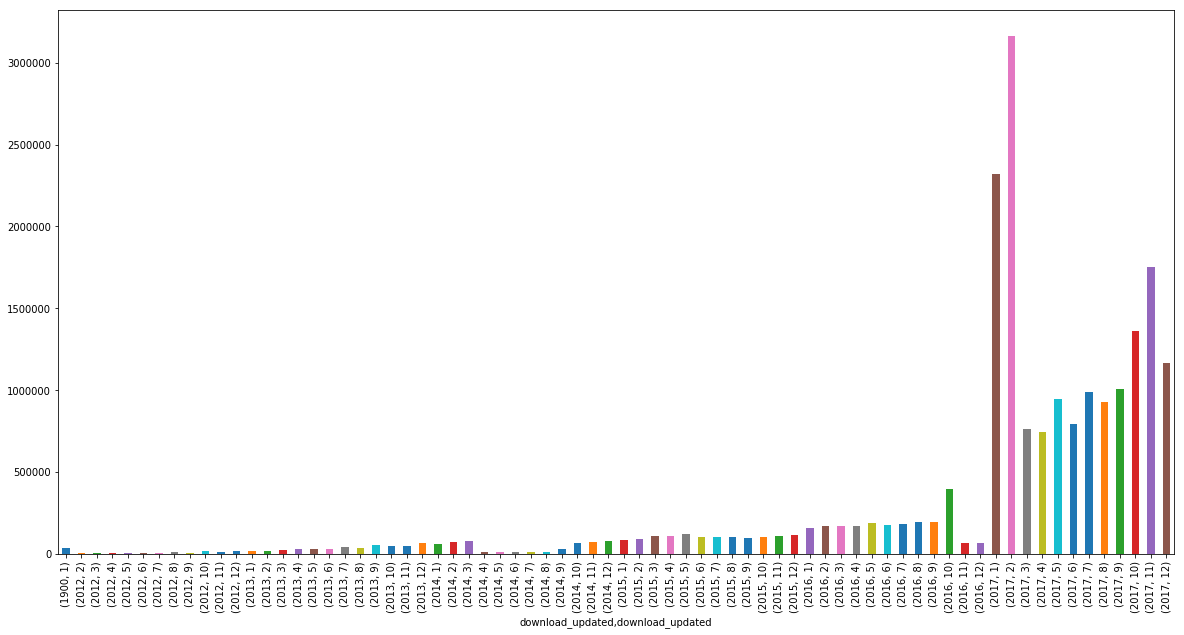

In [12]:
count_by_date = df.fillna(datetime(1900,1,1,0,0,0))
count_by_date = count_by_date.groupby([count_by_date["download_updated"].dt.year, count_by_date["download_updated"].dt.month]).count()
count_by_date['download_updated'].plot(kind="bar", figsize=(20,10))

Viendo esta distribució nos podemos permitir ignorar todo lo ocurrio antes de 2015 pues parede que en gran parte se debió a usuarios que no siguen escuchando, eliminar estos usuarios nos ayuda a eliminar contenido que no genera un seguimiento muy grande de la aplicación, ya que si dejaron la aplicación se puede entender que ese contenido no tenía la suficiente calidad como para mantener a los usuarios usando la aplicación y a nivel económico es más comveniente apoyar el contenido que más engancha.

## Cargamos la base de datos de los programas, por comodidad eliminamos los programas que hemos eliminado antes.

In [8]:
#alguns lineas son ignoradas devido a que no se pueden parsear, la siguiente celda las estudia
programs = pd.read_csv('data/Programs_from_2017.csv', header=0, error_bad_lines=False, warn_bad_lines=False)
programs.columns = ['id', 'name', 'recomendations', 'category', 'subcat', 'audios', 'last_update']
# programs.set_index(['id'])
programs = programs[['id', 'name', 'category', 'subcat']]

print(programs.head())
print(len(programs))
print('\nMemory taken by the dataframe: ' + str(sys.getsizeof(programs)//(2**20)) + 'MB')

    id                          name  category  subcat
0  112  Emprendimientos e Innovación       8.0    37.0
1  146                   Comunicando       8.0    45.0
2  188                   Hoy por Hoy       7.0    31.0
3  189                   El Larguero       3.0    14.0
4  191                     El Albero       5.0    48.0
144548

Memory taken by the dataframe: 14MB


In [9]:
programs['id'] = programs['id'].astype(str)
programs['name'] = programs['name'].astype(str)
programs['category'] = programs['category'].astype('category')
programs['subcat'] = programs['subcat'].astype('category')
programs = programs[programs.id.isin(df.program_id.unique())]

print(programs.head())
print(programs.describe())

print('\nMemory taken by the dataframe: ' + str(sys.getsizeof(programs)//(2**20)) + 'MB')

    id                          name category subcat
0  112  Emprendimientos e Innovación      8.0   37.0
1  146                   Comunicando      8.0   45.0
2  188                   Hoy por Hoy      7.0   31.0
3  189                   El Larguero      3.0   14.0
4  191                     El Albero      5.0   48.0
            id         name  category   subcat
count    20597        20597   20597.0  20553.0
unique   20597        20275       9.0     37.0
top     373263  Entrevistas       0.0      0.0
freq         1           20    4070.0   4023.0

Memory taken by the dataframe: 3MB


# Creando el recommendador

In [10]:
from datetime import datetime
from math import floor

def get_sample(df,p):
    users = df['user_id'].unique()
    if p >1:
        sample = np.random.choice(users, floor(len(users)*p), replace=False)
    elif p==1:
        sample = users
    elif p>0 and p<1:
        sample = np.random.choice(users, floor(len(users)*p), replace=False)
    else:
        return None
    return sample

date = datetime(2016,1,1,0,0,0)

df1 = df[df['download_updated']>date]
df1 = df1[df1['user_id'].isin(df1['user_id'].value_counts(ascending = True).keys()[df1['user_id'].value_counts(ascending = True)>1])]
sample = get_sample(df, 0.05)


print(len(sample))

ivoox_dict = {'Jose':'5209511', 'Fede':'19764', 'Juan':['2982917', '7811817'], 'Miguel':'911419', 'Emilio':'1276315', 'Yo':'6776060', 'Laura':'138931'}
ivoox = ['5209511', '19764', '2982917', '7811817', '911419','1276315', '6776060', '138931']
sample= np.append(sample, ivoox)
sample.sort()
print(sample)

df1 = df1[df1.user_id.isin(sample)]

print('Users: ' + str(df1['user_id'].unique().shape[0]))
print('Programs: ' + str(df1['program_id'].unique().shape[0]))
print(df1.shape)
df1.head()

115885
['1000137' '1000215' '1000556' ..., '999178' '999772' '99996']
Users: 73347
Programs: 37384
(874138, 4)


,user_id,program_id,download_count,download_updated
8610,459,1371,7,2017-03-17 08:31:58
8611,459,3094,20,2017-02-27 00:28:26
8612,459,5802,10,2017-07-22 20:31:55
8613,459,13157,25,2017-02-27 00:28:26
8614,459,16525,1955,2017-11-30 09:34:35


In [14]:
from scipy.sparse import csr_matrix

__ones__ = True

user_u = list(sorted(df1.user_id.unique()))
item_u = list(sorted(df1.program_id.unique()))

row = df1.user_id.astype('category').cat.codes
col = df1.program_id.astype('category').cat.codes

df1['row'] = row


if not __ones__:
    data = df1['download_count'].tolist()
else:
    data = np.ones(df1['download_count'].shape)

# data = df1['download_count'].tolist()

table = csr_matrix((data, (row, col)), shape=(len(user_u), len(item_u)))


In [54]:
df1['listened_frequencies']=df1['download_count'].div(df1['download_count'].sum())
df1.head(5)

,user_id,program_id,download_count,download_updated,listened_frequencies
4198,227,188,10,2017-02-27 00:28:24,5.108327e-08
4199,227,189,7,2017-02-27 00:28:24,3.575829e-08
4200,227,213,38,2017-07-31 00:15:39,1.941164e-07
4201,227,238,20,2017-02-27 00:28:24,1.021665e-07
4202,227,251,146,2017-09-11 07:32:41,7.458158e-07


Normalizaremos los datos para reducir el efecto de los más escuchados, para ello creamos la siguiente función con 2 posibilidades:
* Por filas: se divide cada valor por el total de la fila, esto nos da la proporción de escuchas por usuario.
* Por el pesos: se utiliza el mismo método que para una matriz de contigencia en el caso del análisi de correspondencias.

In [53]:
import scipy.sparse as sparse
def Normalize(table, _technique='row'):
    if _technique == 'row':
        ccd = sparse.spdiags(1./table.sum(1).T, 0, *[table.shape[0],table.shape[0]])
        return ccd*table    
    elif _technique == 'weighted':
        nc = table.sum()
        wm = table.sum(axis=1)/nc
        wn = table.sum(axis=0)/nc
        return table/nc - np.dot(wm,wn)
    elif _technique=='mean':
        mean = sparse.csr_matrix.mean(table, axis=1)
        return table-mean
    else:
        return 0

In [9]:
table = Normalize(table, _technique='row')

In [65]:
from scipy.sparse import linalg

U, s, V = linalg.svds(table, 200)# k=19) #k: numero de variables latentes, el parametro a optimizar
sigma = np.diag(s)


In [41]:
user_recom = np.dot(np.dot(U, sigma), V)
user_recom = pd.DataFrame(user_recom, columns = df1.program_id.astype('category').cat.categories)

user_recom.shape, df1.user_id.unique().shape

(73347,)

In [66]:
row = df1.user_id.astype('category').cat.codes
col = df1.program_id.astype('category').cat.codes

In [97]:
user_row_number = row[df1.user_id.isin(ivoox)].drop_duplicates()
u_recom = np.dot(np.dot(U[user_row_number,:], sigma), V)
u_recom = pd.DataFrame(u_recom, columns = df1.program_id.astype('category').cat.categories)


In [119]:
u_recom.shape


(8, 37384)

In [124]:
def recommend_podcast(predictions, user, programs, original, row, item_u, k=5, _=0):
    # Get and sort the user's predictions
    user_row_number = row #row[df1.user_id == user].iloc[0] # índice en la matriz del usuario
    sorted_user_predictions = predictions.iloc[user_row_number].sort_values(ascending=False)
    sorted_user_predictions = pd.DataFrame(np.array([sorted_user_predictions.index.astype(str), 
                                                     sorted_user_predictions]).T,
                                                     columns=['id', 'Predictions'], )
    # Get the user's data and merge in the movie information.
    user_data = original[_,:].todense().T
    user_df = pd.DataFrame(item_u, columns = ['id'])
    user_df['values'] = user_data
    user_df['id'] = user_df['id'].astype(str)
#     print(user_df)
    user_df = user_df[user_df.values[:,1]>0.0]
    user_full = (user_df.merge(programs[['id','name']], how = 'left', left_on = 'id', right_on = 'id').
                     sort_values(['values'], ascending=False)
                 )
    print('User {0} has already listened to {1} programs.'.format(user, len(user_df)))
    print('Recommending the highest {0} predicted program not already listented.'.format(k))
    sorted_user_predictions['id'] = sorted_user_predictions['id'].astype(str)

    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    intersect = programs[~programs['id'].isin(user_full['id'])]

    recommendations = intersect.merge(sorted_user_predictions,
                                      how = 'left', left_on = 'id', right_on = 'id')
    recommendations = recommendations.sort_values('Predictions', ascending = False).iloc[:k, :]
    
    return user_full, recommendations

In [127]:
n=6

already_rated, predictions = recommend_podcast(u_recom, ivoox[n], programs[['id','name']], table, n, item_u, k=10, _=oooop)


print('Lo que ha escuchado el usuario: ')
print(already_rated.to_string(index=False))
print('\nLo que el recomendador dice: ')
print(predictions.to_string(index=False))
# print(df1[df1['user_id']==user_u[i]].sort_values(['download_count'], ascending=False))

User 6776060 has already listened to 6 programs.
Recommending the highest 10 predicted program not already listented.
Lo que ha escuchado el usuario: 
id  values                                        name
112082     1.0                          Dragones y Camorra
158530     1.0                       Welcome to Night Vale
160064     1.0                   Oh my LOL La Vida Moderna
277537     1.0  MAXIMETAL, Hard Rock & Heavy Metal podcast
455556     1.0               Desde el Abismo - Temporada 4
 56855     1.0            Lo mejor de El Pirata y su Banda

Lo que el recomendador dice: 
id                             name Predictions
 99467         Podcast de Hielo y Fuego     0.07677
432427                La lengua moderna   0.0338415
142576                              Yu    0.0282121
413607      LOCOMUNDO de David Broncano   0.0189396
111999  Juego de Tronos: Cosas de Casas   0.0162958
 81672                     Fans Fiction   0.0162407
 77109                  DESTINO ARRAKIS   0.01571

In [123]:
already_rated, predictions = recommend_podcast(user_recom, ivoox_dict['Yo'], programs[['id','name']], table, row, item_u, k=10)


print('Lo que ha escuchado el usuario: ')
print(already_rated.to_string(index=False))
print('\nLo que el recomendador dice: ')
print(predictions.to_string(index=False))
# print(df1[df1['user_id']==user_u[i]].sort_values(['download_count'], ascending=False))

User 6776060 has already listened to 6 programs.
Recommending the highest 10 predicted program not already listented.
Lo que ha escuchado el usuario: 
id  values                                        name
112082     1.0                          Dragones y Camorra
158530     1.0                       Welcome to Night Vale
160064     1.0                   Oh my LOL La Vida Moderna
277537     1.0  MAXIMETAL, Hard Rock & Heavy Metal podcast
455556     1.0               Desde el Abismo - Temporada 4
 56855     1.0            Lo mejor de El Pirata y su Banda

Lo que el recomendador dice: 
id                             name Predictions
 99467         Podcast de Hielo y Fuego     0.07677
432427                La lengua moderna   0.0338415
142576                              Yu    0.0282121
413607      LOCOMUNDO de David Broncano   0.0189396
111999  Juego de Tronos: Cosas de Casas   0.0162958
 81672                     Fans Fiction   0.0162407
 77109                  DESTINO ARRAKIS   0.01571

## Todo esto funciona muy bien para recomendar y que quede bonito y de golpe

Pero no es necesario calcular el producto $U \cdot \Sigma \cdot V$, podemos calcular el producto de un usuario o de una fracción de los usuarios, lo que no consume tanta memoria. En la última celda se muestran los tiempos para el cálculo de la SVD para distintos pordentager de la base de datos, que como se ve no es necesario demasiado para todos los usuarios.

In [42]:
for i in [0.1, 0.3, 0.5, 0.8, 1]:
    df1 = df[df['download_updated']>date]
    df1 = df1[df1['user_id'].isin(df1['user_id'].value_counts(ascending = True).keys()[df1['user_id'].value_counts(ascending = True)>1])]
    sample = get_sample(df1, i)
    df1 = df1[df1.user_id.isin(sample)]
    
    __ones__ = True

    user_u = list(sorted(df1.user_id.unique()))
    item_u = list(sorted(df1.program_id.unique()))

    row = df1.user_id.astype('category').cat.codes
    col = df1.program_id.astype('category').cat.codes

    
    
    if not __ones__:
        data = df1['download_count'].tolist()
    else:
        data = np.ones(df1['download_count'].shape)

    # data = df1['download_count'].tolist()

    table = csr_matrix((data, (row, col)), shape=(len(user_u), len(item_u)))
    %timeit U, s, V = linalg.svds(table, 200)# k=19) #k: numero de variables latentes, el parametro a optimizar
    print(i)

13.2 s ± 41 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
0.1
21.8 s ± 108 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
0.3
27.6 s ± 81.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
0.5
35.4 s ± 256 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
0.8
40.4 s ± 117 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1


In [ ]:
def optimized_recommend_podcast(predictions, user, original, row, item_u, k=int(5)):
    # Get and sort the user's predictions
    user_row_number = user # índice en la matriz del usuario # índice en la matriz del usuario
    sorted_user_predictions = predictions.iloc[0].sort_values(ascending=False)
    sorted_user_predictions = pd.DataFrame(np.array([sorted_user_predictions.index, 
                                                     sorted_user_predictions]).T,
                                                     columns=['id', 'Predictions'])
    # Get the user's data and merge in the movie information.
    
    user_data = original[user_row_number,:].todense().T
    user_df = pd.DataFrame(item_u, columns = ['id'])
    user_df['values'] = user_data
    user_df = user_df[user_df.values[:,1]>0.0].sort_values(['values'], ascending=False)
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = sorted_user_predictions[~sorted_user_predictions['id'].isin(user_df['id'])].iloc[:k, :]
    return recommendations

## Para la base con solo las escuchas actualizadas desde Junio
* 0.1:
13.2 s ± 41 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
* 0.3:
21.8 s ± 108 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
* 0.5:
27.6 s ± 81.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
* 0.8:
35.4 s ± 256 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
* 1:
40.4 s ± 117 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

# Validar los resultados

Una vez tenemos un sistema como el de ahora, toca validar los resultados, para ello se usará 10-fold cross validation, lo que significa que testearemos colos resultados dividiendo la base de datos en 10. 

Para los experimentos anteriores se utilizo solo el 5% de los datos que se actualizaron desde el 31 de noviembre hasta el 9, más o menos ahora utilizaremos más. Por lo tanto lo primero es obtener una muestra balanceada y que represente correctamente a la población.

In [130]:
from tqdm import tqdm
from math import floor
import time
import datetime
import scipy.sparse as sparse
from scipy.sparse import csr_matrix, linalg


def get_testing_programs(df, m):
    users = df.user_id.unique().tolist()
    hidden = pd.DataFrame()
    for u in tqdm(users):
        a = df[df['user_id']==u].sample(m)
        df = df.drop(a.index)
        hidden = hidden.append(a)
    return df, hidden


def get_testing_one(df):
    users = df.user_id.unique().tolist()
    h = pd.DataFrame()
    for u in tqdm(users):
        m = sum(df['user_id']== u)
        a = df[df['user_id']==u].sample(m-1)
        h = h.append(a)
        df = df.drop(a.index)
    return df, h


def get_testing_high_prog(df, m):
    users = df.user_id.unique().tolist()
    hidden = pd.DataFrame()
    for u in tqdm(users):            
        d = df[df['user_id']==u]
        a = df[df['user_id']==u].sort_values('download_count', ascending = False).iloc[:m, :]
        df = df.drop(a.index)
        hidden = hidden.append(a)
    return df, hidden


def get_testing_high_one(df):
    users = df.user_id.unique().tolist()
    h = pd.DataFrame()
    for u in tqdm(users):
        d = df[df['user_id']==u]
        m = sum(df['user_id']== u)
        a = df[df['user_id']==u].sort_values('download_count', ascending = False).iloc[:m-1, :]
        h = h.append(a)
        df = df.drop(a.index)
    return df, h


def get_sample(df, p, ivoox = None):
    users = df['user_id'].unique()
    sample = np.random.choice(users, floor(len(users)*p), replace=False)
    if ivoox:
        sample= np.append(sample, ivoox)
    return sample
    
    
def get_test(df, p, m = 2, random = True):
#     not_sampled = df[~df['user_id'].isin(sample)].user_id.unique()
    users = df['user_id'].unique()
    user_test = np.random.choice(users, floor(len(users)*p), replace=False)
    df1 = df[df['user_id'].isin(user_test)]
    df = df[~df['user_id'].isin(user_test)]

    one = df1[df1['user_id'].isin(df1['user_id'].value_counts(ascending = True).keys()[df1['user_id'].value_counts(ascending = True)<=m])]
    two = df1[df1['user_id'].isin(df1['user_id'].value_counts(ascending = True).keys()[df1['user_id'].value_counts(ascending = True)>m])]
    
    print('Obteniendo partición de test y el ground true, puede tomar algún tiempo.')
    if random:
        one, test1 = get_testing_one(one)
        two, test2 = get_testing_programs(two, m)
    else:
        one, test1 = get_testing_high_one(one)
        two, test2 = get_testing_high_prog(two, m)
    df = df.append(one)
    df = df.append(two)
    return df,  test1.append(test2)


def get_table(df, __ones__=False):
    user_u = list(sorted(df.user_id.unique()))
    item_u = list(sorted(df.program_id.unique()))

    row = df.user_id.astype('category').cat.codes
    col = df.program_id.astype('category').cat.codes
    
    df1['row']=row
    df1['col']=col
    
    if not __ones__:
        data = df['download_count'].tolist()
        table = csr_matrix((data, (row, col)), shape=(len(user_u), len(item_u)))
    else:
        data = np.ones(df['download_count'].shape)
        table = csr_matrix((data, (row, col)), shape=(len(user_u), len(item_u)))

    return df1, table


def Normalize(table, _technique='row'):
    if _technique == 'row':
        ccd = sparse.spdiags(1./table.sum(1).T, 0, *[table.shape[0],table.shape[0]])
        return ccd*table
    elif _technique == 'weighted':
        nc = table.sum()
        wm = table.sum(axis=1)/nc
        wn = table.sum(axis=0)/nc
        return table/nc - np.dot(wm,wn)
    else:
        return 0


def recommend_whole(df, U, sigma, V, k, num_batches=1):

    St = np.dot(sigma, V)
    
    rows = df[['user_id', 'row']].drop_duplicates()
    cols = df[['program_id', 'col']].drop_duplicates()
    
    item_u = np.array(sorted(df.program_id.unique()))
    user_u = np.array(sorted(df.user_id.unique()))
    
    batches = np.array_split(user_u, num_batches)
    all_recom = dict()
    
    for i in range(num_batches):
        t1 = time.time()
        user_batch = batches[i]
        user_prog = df[df['user_id'].isin(user_batch)]
        user_prog = user_prog[['user_id', 'program_id']]
        recom = recommend(U, St, user_batch, rows, cols, user_prog, np.array(item_u), k)
        #meter quitar los escuchados
        all_recom.update(recom) 
        print(i, time.time()-t1)
        break
    return all_recom


def recommend(U, St, user_batch, rows, cols, user_prog, item_u, k):
#     predictions, user, programs, original, row, item_u, k=5
    # Get and sort the user's predictions
    aux = rows.user_id.isin(user_batch)
    user_row_number = rows[aux].row.values # índice en la matriz del usuario, ver si coinviden con los usuarios(justo abajo)
    users = rows[aux].user_id.values
    predicted = np.dot(U[user_row_number,:], St)
    prog = dict()

    for i in range(len(predicted)):
        listened_prog = user_prog[user_prog.user_id==users[i]].program_id.values
        u_cols = cols[~cols.program_id.isin(listened_prog)].col
        current = predicted[i,u_cols]
        ind = current.argsort()[-1:-k-1:-1]
        prog[users[i]] = item_u[list(ind)]
#         print(item_u[ind])
    return prog


In [217]:
# Quitamos los usuarios que solo han escuchado 1 programa ya que no aportan al test, en el que introduciremos usuarios con 1 programa manual y calcularemos que les recomiendan
df1 = df[df['user_id'].isin(df['user_id'].value_counts(ascending = True).keys()[df['user_id'].value_counts(ascending = True)>1])]
sample = get_sample(df1, 0.1)
df1 =  df1[df1.user_id.isin(sample)]

df1, truth = get_test(df1, 0.1, m=1, random=True)

print('Tamaño de la base de datos: '+str(len(df1))+'. Con un total de '+str(len(sample))+' usuarios y '+str(len(df1.program_id.unique()))+' programas.')
print('En testing tenemos un total de '+str(len(truth))+' datos. Con un total de '+str(len(truth.user_id.unique()))+' usuarios y '+str(len(truth.program_id.unique()))+' programas.')


Una vez seleccionados los usuarios de test hallamos la tabla con valores y su descomposición en valores singulares. Después de ello hallamos las recomendaciones.

In [63]:
df1, table = get_table(df1, __ones__=True)
# table = Normalize(table, _technique='row')

print('Obteniendo SVD, puede llevar algún tiempo.')
U, s, V = linalg.svds(table, k =200)# k=19) #k: numero de variables latentes, el parametro a optimizar
sigma = np.diag(s)

print('SVD obtenida, haciendo el producto de matrices para la recomendación.')
r = recommend_whole(df1, U, sigma, V, k=10, num_batches=10)

Obteniendo SVD, puede llevar algún tiempo.
SVD obtenida, haciendo el producto de matrices para la recomendación.
1467
1467
0 17.461426496505737


In [14]:
r = recommend_whole(df1, U, sigma, V, k=10, num_batches=50)

0 17.492345571517944


In [136]:
np.max(np.dot(U[user_row_number,:], np.dot(sigma,V)) - np.dot(np.dot(U[user_row_number,:],sigma), V))

3.3306690738754696e-16

In [131]:
rows = df1[['user_id', 'row']].drop_duplicates()
cols = df1[['program_id', 'col']].drop_duplicates()

user_batch=ivoox

user_prog = df1[df1['user_id'].isin(user_batch)]
user_prog = user_prog[['user_id', 'program_id']]

item_u = np.array(sorted(df1.program_id.unique()))

d = recommend(U, np.dot(sigma, V), user_batch, rows, cols, user_prog, item_u, 10)

i = 6

print(list(d.values())[i])
print(programs[programs.id.isin(d[list(d.keys())[i]])])
sum(['99467' in i for i in d.values()]), sum(['160064' in i for i in d.values()])

['100653' '11036' '102470' '100166' '107929' '113934' '110381' '113100'
 '114552' '101721']
          id                           name category subcat
5309  100653  Radio Torredelcampo & Juan MQ      0.0    0.0
5900  113100   Podcast de Cristóbal Cabezas      0.0    0.0


(0, 0)

In [ ]:
def test_recommender(r, truth):
    n=0
    k=0
    o=0
    for u in tqdm(list(truth.user_id.unique())):
        truth_u = truth[truth.user_id == u]
        truth_u = truth_u.program_id.tolist()

        predictions = r[u]
        if len(truth_u)==1:
            o+=1
            if len(set(predictions).intersection(truth_u))>=1:
                n+=1
                k+=1
        elif len(set(predictions).intersection(truth_u))>=1:
            n+=1
    return  n/len(truth.user_id.unique())*100, k/o*100,(n-k)/(len(truth.user_id.unique())-o)*100

def test_k_norm(df, truth, K, N):
    for k in K:
        for norm in N:
            print('calculating for k='+str(k)+' and norm: '+norm)
            if norm == 'No':
                df1, table = get_table(df1, __ones__=True)
            else:
                df1, table = get_table(df1, __ones__=False)
                table = Normalize(table, _technique=norm)

            U, s, V = linalg.svds(table, k =k)
            sigma = np.diag(s)
            r = recommend_whole(df1, U, sigma, V, k=10, num_batches=10) 
            acc, acc_one, acc_no_one = test_recommender(r, truth)
            print('Total Accuracy of: '+str(acc))
            print('One listened Accuracy of: '+str(acc_one))            
            print('Accuracy for more than one litened: '+str(acc_no_one))  
            print('\n')

In [175]:
n=0
k=0
o=0
for u in tqdm(list(truth.user_id.unique())):
    truth_u = truth[truth.user_id == u]
    truth_u = truth_u.program_id.tolist()

    predictions = r[u]
    if len(truth_u)==1:
        o+=1
        if len(set(predictions).intersection(truth_u))>=1:
            n+=1
            k+=1
    elif len(set(predictions).intersection(truth_u))>=1:
        n+=1
    
print('Precisión: ' + str(n/len(truth.user_id.unique())*100) + '%')
print('Precisión de los usuarios con 1 escucha: ' + str(k/o*100) + '%')
print('Precisión del resto: ' + str((n-k)/(len(truth.user_id.unique())-o)*100) + '%')

NameError: name 'truth' is not defined

In [93]:
%timeit recomend(U[5,:], sigma, V)

5.47 ms ± 24.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Creando el Código del Recomendador

In [77]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
import scipy.sparse as sparse
from scipy.sparse import csr_matrix, linalg

class Recomendador:
    algorithm = 'SVD'
    def __init__(self, data_dir=None, k=None, programas_dir=None):
        '''
        Constructor del objeto recommendador
        data_dir: directorio con el csv para los datos
        k: número componentes para el SVD
        programas_dir: directorio para programas
        '''
        
        if data_dir:
            self.original = pd.read_csv(data_dir, header=0)
            self.original.columns = ['user_id', 'program_id', 'download_count', 'download_updated']
        if programas_dir:
            self.programas_df = pd.read_csv(programas_dir, header=0, error_bad_lines=False, warn_bad_lines=False)
            self.programas_df.columns = ['id', 'name', 'recomendations', 'category', 'subcat', 'audios', 'last_update']
            self.programas_df = self.programas_df[['id', 'name', 'category', 'subcat']]
        if k:
            self.k = k
        self.description = "Sistema de recomendación basado en SVD para ivoox"
        self.author = "Jorge Rodriguez Molinuevo"
        
    def tipos_correctos(self):
        '''Define cada variable dandole el tipo correcto de valor en la tabla de usuarios programas escuchas '''
        
        self.original["user_id"] = self.original["user_id"].astype(str)
        self.original["program_id"] = self.original["program_id"].astype(str)
        self.original['download_count'] = self.original['download_count'].astype(int)
        self.original['download_updated'] = pd.to_datetime(self.original['download_updated'], errors = 'coerce')
        self.users = self.original['user_id'].unique()
        self.programs = self.original['program_id'].unique()
    
    def tipos_programas(self):
        '''Define cada variable dandole el tipo correcto de valor en la tabla de programas '''
        
        self.programas_df['id'] = self.programas_df['id'].astype(str)
        self.programas_df['name'] = self.programas_df['name'].astype(str)
        self.programas_df['category'] = self.programas_df['category'].astype('category')
        self.programas_df['subcat'] = self.programas_df['subcat'].astype('category')
        self.programas_df = self.programas_df[self.programas_df.id.isin(self.original.program_id.unique())]
        
    def preproccess(self, date=datetime.now() - relativedelta(years=2), k=10):
        ''' 
        Transformación de los datos de para reducir las dimensiones de los datos y mejorar la preción del recomendador
        eliminando ruido en la matriz, como programas con pocos oyentes.
        '''
        #Primero eliminamos programas de sobra
        entradas_origen = len(self.original)
        count_prog = self.original.groupby('program_id')['user_id'].nunique()
        programas_fecha = self.original[self.original['download_updated']>date].program_id.unique() #programas que se han escuchado una vez desde 2015
        self.original = self.original[self.original.program_id.isin(programas_fecha)]
        rango_oyentes = range(1,k+1)
        programas_oyentes = self.original[~self.original.program_id.isin(count_prog[count_prog.isin(rango_oyentes)].index)].program_id.unique()#programas que solo son escuchados entre 1 y 10 
        self.original = self.original[self.original.program_id.isin(programas_oyentes)]
        
        #Ahora se eliminan usuarios
        usuarios_fecha = self.original[self.original['download_updated']>date].user_id.unique() #programas que se han escuchado una vez desde 2015
        self.original = self.original[self.original.user_id.isin(usuarios_fecha)]

        #eliminamos de nuevo programas con poca audiencia en caso de que los usuarios eliminados hallan podido cambiar la distribución
        rango_oyentes = range(1,11)
        count_prog = self.original.groupby('program_id')['user_id'].nunique()
        programas_oyentes = self.original[~self.original.program_id.isin(count_prog[count_prog.isin(rango_oyentes)].index)].program_id.unique()

        print('Antes teníamos ' + str(len(self.users)) + ', ahora tenemos un total de ' + str(len(self.original.user_id.unique())) + ' usuarios.')
        print('Antes teníamos ' + str(len(self.programs)) + ', ahora tenemos un total de ' + str(len(self.original.program_id.unique())) + ' programas.')
        print('Ésto implica que de una base de datos de ' + str(entradas_origen) + ' de entradas hemos pasado a una con ' + str(len(self.original)) + ' entradas.')
        self.users = self.original['user_id'].unique()
        self.programs = self.original['program_id'].unique()
        
        
        
    def __get_table__(self, __ones__=False):
        '''
        Función para obtener la tabla de usuarios por programas 
        df: es el dataframe con los datos
        __ones__: variable que define si usar 1s en vez de las descargas
        '''
        
        user_u = list(sorted(self.original.user_id.unique()))
        item_u = list(sorted(self.original.program_id.unique()))

        row = self.original.user_id.astype('category').cat.codes
        col = self.original.program_id.astype('category').cat.codes
        
        self.original['row']=row
        self.original['col']=col

        if not __ones__:
            data = self.original['download_count'].tolist()
        else:
            data = np.ones(self.original['download_count'].shape)
        table = csr_matrix((data, (row, col)), shape=(len(user_u), len(item_u)))
        
        self.row = row
        self.col = col
        self.table = table
        return row, col, table
    
    def Normalize(self, _technique='row'):
        '''
        Función utilizada en el momento de querer normalizar los datos por ahora se han ofrecido 2 técnicas
        pero ninguna ofrece mejore resultados que el no utilizar nada, se mantiene el método a la espera de 
        encontrar alguna técnica que mejore los resultados
        _technique define la técnica
        '''
        
        if _technique == 'row':
            ccd = sparse.spdiags(1./self.table.sum(1).T, 0, *[table.shape[0],table.shape[0]])
            self.table = ccd*self.table
        elif _technique == 'weighted':
            nc = self.table.sum()
            wm = self.table.sum(axis=1)/nc
            wn = self.table.sum(axis=0)/nc
            self.table = self.table/nc - np.dot(wm,wn)
        else:
            return 0
        
    def SVD(self, k = None):
        ''' 
        Descomposición en valores singulares utilizando scipy.linalg.svds para poder reducir la matriz de dimensión
        k: número de componentes principales
        '''
        if not k:
            k = self.k
            
        row, col, table = self.__get_table__

        U, s, V = linalg.svds(self.table, k = k)
        sigma = np.diag(s)
        self.U = U
        self.sigma = sigma
        self.V = V
        return U, sigma, V

    def __recommend_batch__(self, user_batch, rows, cols, listened_prog, item_u, k):
        '''
        Obtener las recomendacones de un batch, función privada
        '''
        aux = rows.user_id.isin(user_batch)
        user_row_number = rows[aux].row.values # índice en la matriz del usuario
        users = rows[aux].user_id.values
        predicted = np.dot(self.U[user_row_number,:], self.St)

        prog = {}

        for i in range(len(predicted)):
            u_cols = cols[~cols.program_id.isin(listened_prog)].col
            current = predicted[i,u_cols]
            ind = current.argsort()[-1:-k-1:-1]
            prog[users[i]] = item_u[ind]
        return prog
    
    def recommend_whole(self, k=5, num_batches=1):
        
        St = np.dot(sigma, V)
        self.St = St

        rows = self.original[['user_id', 'row']].drop_duplicates()
        cols = self.original[['program_id', 'col']].drop_duplicates()


        item_u = list(sorted(self.original.program_id.unique()))
        user_u = list(sorted(self.original.user_id.unique()))

        batches = np.array_split(user_u, num_batches)
        self.all_recom = dict()

        for i in range(num_batches):
            user_batch = batches[i]
            listened_prog = self.original[self.original.user_id.isin(user_batch)][['user_id', 'program_id']]
            recom = self.__recommend_batch__(user_batch, rows, cols, listened_prog, np.array(item_u), k)
            #meter quitar los escuchados
            self.all_recom.update(recom) 
        return self.all_recom
    
    def recommend(self, user):
        if not self.programas_df:
            return self.all_recom[user]
        else:
            progs = self.all_recom[user]
        return self.programas_df[self.programas_df.isin(progs)]
    

In [66]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

def run():
    Rec = Recomendador(data_dir='data/user_program_count.csv', k=200)
    Rec.tipos_correctos()
    date = datetime.now() - relativedelta(years=2)
    Rec.preproccess(date=date, k=10):
    U, sigma, V = Rec.SVD()
    Rec.recommend_whole(k=5, num_batches=20)
    return Rec


In [35]:
len(df)/len(df1)

23.659662414984766

In [41]:
t = np.array([30.526554346084595, 28.089844703674316, 31.209049463272095, 31.80046796798706, 28.78733539581299, 30.069243669509888, 31.871517181396484, 32.733126401901245, 29.953160285949707, 29.558884859085083])
t.mean(), t.sum()//60

(30.459918427467347, 5.0)

In [42]:
print(len(df1.user_id.unique()))
print(len(df.user_id.unique())/len(df1.user_id.unique()))
print('Expected time for the whole dataset: '+ str(t.sum()*len(df.user_id.unique())/len(df1.user_id.unique())//60) )

73808
45.21581671363538
Expected time for the whole dataset: 229.0


In [141]:
St = np.dot(sigma, V)
k = 5
user_batch = ivoox
%timeit recommend(U, St, user_batch, rows, np.array(item_u), k)

3.57 ms ± 13.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


array([ 7605, 37132, 20740, 27676, 21334], dtype=int64)

In [131]:
for i in range(len(col)):
    if not col.iloc[i] == item_u.index(df1.iloc[i].program_id):
        print(i)

In [122]:
item_u.index(df1.iloc[35].program_id)

12204